In [1]:
import csv
import numpy as np
import keras
from keras import losses, regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
import h5py
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
from helpers import normalize_data

Using TensorFlow backend.


In [84]:
### Load the data ###

# Data after normalization with Metabo Analyst 4.0
with open("C:/Users/wolfgang.schwab/Desktop/Lokal/RocheDataChallenge/MetaboAnalyst_merged_data_comma.csv") as f:
  dataset_log2 = f.readlines()
# Raw data
with open("C:/Users/wolfgang.schwab/Desktop/Lokal/RocheDataChallenge/Expressiondata.txt") as f:
  dataset_unnormed = f.readlines()

In [87]:
### Data preprocessing ###

labels = np.asarray([1 if x =='adenocarcinoma' else 0 for x in complete_dataset[1].split(';')[1:]], dtype = int)

complete_data_split = []
for line in complete_dataset:
    complete_data_split.append(line.replace(",",".").split(';')[1:])  
    

data_log2 = np.asarray(complete_data_split[2:][1:], dtype = float)
data_normed = normalize_data(dataset_unnormed, normalization = "MinMax")

print(data_normed.shape)
print(data_log2.shape)

data_transp = np.transpose(data_log2)
data_train, data_val, label_train, label_val = train_test_split(data_transp, labels, test_size=0.2)

(23444, 594)
(23444, 594)


In [322]:
### Selection of biomarkers used for classification ###

#biomarker_ids = [0, 1]
#biomarker_ids = [1220, 7193] ## TP63 and NKX2-1
biomarker_ids = [1527,3260] ## lowest pval score
biomarkers = [x - 1 for x in biomarker_ids]
data_train_selected = data_train[:,biomarkers]
data_val_selected = data_val[:,biomarkers]

In [323]:
### Building the neural network ###

model = Sequential()
model.add(Dense(5, activation='relu',input_shape = (len(biomarkers),),kernel_initializer='random_normal'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='relu',input_shape = (len(biomarkers),),kernel_initializer='random_normal'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid',kernel_initializer='random_normal'))

In [324]:
### Training the neural network ### 
adam_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
rms_opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model.compile(optimizer =adam_opt,loss='binary_crossentropy', metrics =['accuracy'])

checkpointer = ModelCheckpoint(filepath='RDC.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(data_train_selected,label_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[checkpointer])       

Train on 427 samples, validate on 48 samples
Epoch 1/100
427/427 [==============================] - 2s 5ms/step - loss: 0.6926 - acc: 0.5785 - val_loss: 0.6933 - val_acc: 0.4792

Epoch 00001: val_loss improved from inf to 0.69329, saving model to RDC.hdf5
Epoch 2/100
427/427 [==============================] - 0s 61us/step - loss: 0.6911 - acc: 0.6042 - val_loss: 0.6933 - val_acc: 0.4792

Epoch 00002: val_loss did not improve from 0.69329
Epoch 3/100
427/427 [==============================] - 0s 122us/step - loss: 0.6893 - acc: 0.6042 - val_loss: 0.6930 - val_acc: 0.4792

Epoch 00003: val_loss improved from 0.69329 to 0.69304, saving model to RDC.hdf5
Epoch 4/100
427/427 [==============================] - 0s 105us/step - loss: 0.6870 - acc: 0.6042 - val_loss: 0.6922 - val_acc: 0.4792

Epoch 00004: val_loss improved from 0.69304 to 0.69225, saving model to RDC.hdf5
Epoch 5/100
427/427 [==============================] - 0s 89us/step - loss: 0.6836 - acc: 0.6042 - val_loss: 0.6907 - val_ac

Epoch 39/100
427/427 [==============================] - 0s 77us/step - loss: 0.4747 - acc: 0.8806 - val_loss: 0.4687 - val_acc: 0.8750

Epoch 00039: val_loss improved from 0.47132 to 0.46871, saving model to RDC.hdf5
Epoch 40/100
427/427 [==============================] - 0s 75us/step - loss: 0.4724 - acc: 0.8735 - val_loss: 0.4661 - val_acc: 0.8750

Epoch 00040: val_loss improved from 0.46871 to 0.46609, saving model to RDC.hdf5
Epoch 41/100
427/427 [==============================] - 0s 82us/step - loss: 0.4666 - acc: 0.8735 - val_loss: 0.4633 - val_acc: 0.8750

Epoch 00041: val_loss improved from 0.46609 to 0.46329, saving model to RDC.hdf5
Epoch 42/100
427/427 [==============================] - 0s 77us/step - loss: 0.4691 - acc: 0.8829 - val_loss: 0.4609 - val_acc: 0.8750

Epoch 00042: val_loss improved from 0.46329 to 0.46086, saving model to RDC.hdf5
Epoch 43/100
427/427 [==============================] - 0s 72us/step - loss: 0.4701 - acc: 0.8829 - val_loss: 0.4588 - val_acc: 0.87

427/427 [==============================] - 0s 112us/step - loss: 0.4400 - acc: 0.8829 - val_loss: 0.4066 - val_acc: 0.8958

Epoch 00077: val_loss improved from 0.40806 to 0.40658, saving model to RDC.hdf5
Epoch 78/100
427/427 [==============================] - 0s 65us/step - loss: 0.4420 - acc: 0.8735 - val_loss: 0.4051 - val_acc: 0.8958

Epoch 00078: val_loss improved from 0.40658 to 0.40511, saving model to RDC.hdf5
Epoch 79/100
427/427 [==============================] - 0s 72us/step - loss: 0.4448 - acc: 0.8689 - val_loss: 0.4046 - val_acc: 0.8958

Epoch 00079: val_loss improved from 0.40511 to 0.40457, saving model to RDC.hdf5
Epoch 80/100
427/427 [==============================] - 0s 103us/step - loss: 0.4489 - acc: 0.8712 - val_loss: 0.4037 - val_acc: 0.8958

Epoch 00080: val_loss improved from 0.40457 to 0.40375, saving model to RDC.hdf5
Epoch 81/100
427/427 [==============================] - 0s 77us/step - loss: 0.4410 - acc: 0.8689 - val_loss: 0.4027 - val_acc: 0.8958

Epoch 0

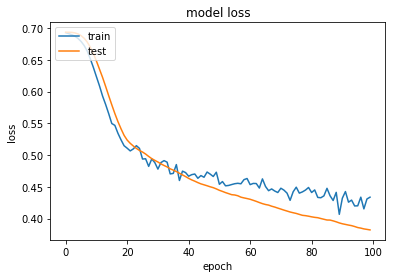

In [325]:
### Display the loss ###

model.load_weights('RDC.hdf5')

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [326]:
### Evaluation of neural network accuracy ###

result = model.evaluate(data_val_selected, label_val)
print("Accuracy of model is: " + str(100 * result[1]) + "%")

119/119 [==============================] - 0s 176us/step
Accuracy of model is: 92.43697499026771%


In [328]:
### Create a svm Classifier ###

clf = svm.SVC(kernel='rbf', gamma = 'auto') # Linear Kernel
clf.fit(data_train_selected, label_train)
label_pred = clf.predict(data_val_selected)
print("Accuracy:",metrics.accuracy_score(label_val, label_pred))
X = data_val_selected
y = label_val

Accuracy: 0.9243697478991597


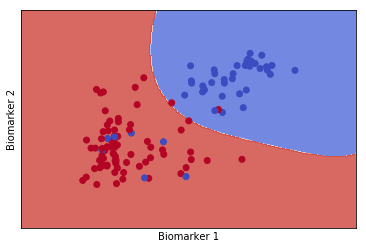

In [329]:
### Display SVM classification result ###

h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()

In [330]:
### Display confusion matrix for SVM ###

cm = np.array(confusion_matrix(label_val,label_pred,[1,0]))
confusion = pd.DataFrame(cm, index = ['is_AC','is_SC'], columns = ['predicted_AC','predicted_SC'])
confusion

,predicted_AC,predicted_SC
is_AC,73,2
is_SC,7,37
